# 1. Ensemble Learning overview
Classical Machine Learning algorithms are usually shown to be poor when handling real-world datasets. Models fit from these algorithms often suffer from two problems: high bias and high variance; such a model is called a *weak learner*. In this topic, we are going through some elegant techniques that combine multiple weak learners to form a powerful model, which produces an improved overall result. This is referred to generally as [Ensemble Learning](https://en.wikipedia.org/wiki/Ensemble_learning). Enemble Learning methods have proven their effectiveness in many Machine Learing competitions.

## 1.1. Voting
[Voting](https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier) (for classification) or [Averaging](https://scikit-learn.org/stable/modules/ensemble.html#voting-regressor) (for regression) is the simplest ensembling method. When doing voting for classification, there are two strategies can be applied: marjority voting on predicted results (hard voting) and taking argmax of the weighted average of predicted probabilities (soft voting).

In [11]:
import numpy as np
import pandas as pd
np.set_printoptions(precision=4, suppress=True)

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, VotingRegressor

In [41]:
dfCancer = pd.read_csv('data/breast_cancer.csv')
x = dfCancer.drop(columns='target')
y = dfCancer.target
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=1/5, random_state=1)
xTrain, xValid, yTrain, yValid = train_test_split(xTrain, yTrain, test_size=1/4, random_state=1)

In [42]:
clf1 = SVC(probability=True)
clf2 = LogisticRegression(solver='liblinear')
clf3 = DecisionTreeClassifier()

modelsBase = [clf1, clf2, clf3]
modelsBaseNamed = [(model.__class__.__name__, model) for model in modelsBase]
ensembler = VotingClassifier(modelsBaseNamed, voting='soft')

In [43]:
for model in modelsBase + [ensembler]:
    model = model.fit(xTrain, yTrain)
    yPred = model.predict_proba(xTest)[: ,1]
    auc = roc_auc_score(yTest, yPred)
    print(f'AUC = {auc:.4f} [{model.__class__.__name__}]')

AUC = 0.9464 [SVC]
AUC = 0.9931 [LogisticRegression]
AUC = 0.8512 [DecisionTreeClassifier]
AUC = 0.9851 [VotingClassifier]


## 1.2. Stacking
[Stacking](https://scikit-learn.org/stable/modules/ensemble.html#stacked-generalization) technique organizes its members into two levels:
- Level 1, a number of *base models* is fit to ther dataset. Build a new dataset where the values predicted by base models are input variables while the output variable remains the same.
- Level 2, a *meta model* is train on the new dataset to get final prediction.

The idea behind stacking is that each base model has an unique approach, it might discover some parts of the ground truth that other models do hot have. Combining them might utilize the their strengths and thus improve the overall quality. Note that Voting is a special case of Stacking, where the final combiner is a very simple model.

In the implementation of Stacking, the base models are often selected *heterogeneously*, and the meta model is often a simple Logistic Regression model.

In [12]:
import numpy as np
import pandas as pd
np.set_printoptions(precision=4, suppress=True)

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, StackingRegressor

In [39]:
dfCancer = pd.read_csv('data/breast_cancer.csv')
x = dfCancer.drop(columns='target')
y = dfCancer.target
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=1/5, random_state=1)
xTrain, xValid, yTrain, yValid = train_test_split(xTrain, yTrain, test_size=1/4, random_state=1)

In [45]:
clf1 = KNeighborsClassifier()
clf2 = GaussianNB()
clf3 = SVC(probability=True)
clf4 = LogisticRegression(solver='liblinear')
clf5 = DecisionTreeClassifier()

modelsBase = [clf1, clf2, clf3, clf4, clf5]
modelsBaseNamed = [(model.__class__.__name__, model) for model in modelsBase]
modelMeta = LogisticRegression()

ensembler = StackingClassifier(modelsBaseNamed, modelMeta)

In [46]:
for model in modelsBase + [ensembler]:
    model = model.fit(xTrain, yTrain)
    yPred = model.predict_proba(xTest)[: ,1]
    auc = roc_auc_score(yTest, yPred)
    print(f'AUC = {auc:.4f} [{model.__class__.__name__}]')

AUC = 0.9568 [KNeighborsClassifier]
AUC = 0.9775 [GaussianNB]
AUC = 0.9464 [SVC]
AUC = 0.9931 [LogisticRegression]
AUC = 0.8442 [DecisionTreeClassifier]
AUC = 0.9891 [StackingClassifier]


## 1.3. Bagging
[Bootstrap Aggregating](https://scikit-learn.org/stable/modules/ensemble.html#bagging-meta-estimator) (Bagging) uses averaging/voting method over a number of *homogeneous* weak models in order to reduce variance. Specifically, Bagging is divided into two parts: [bootstrapping](<https://en.wikipedia.org/wiki/Bootstrapping_(statistics)>) and aggregating.

- Boostrapping: The entire dataset is performed random sampling with replacement on both rows and columns. This outputs a number of bootstraps where each of them is different from the others.
- Aggregating: after boostrap samples are generated, they are fit into the weak learners. All the model results will be combined by averaging (for regression) or voting (for classification).

A Bagging ensembler operates as a committee that outperforms any individual weak model. This wonderful effect - *the wisdom of crowds* - can be explained that weak models protect each other from their individual errors. If the members share the same behaviors, they also make the same mistakes. Therefore, the low correlation between weak models is the key. Note that the Bagging method requires the initial sample to be large enough for the bootstrapping step to be statistical significant.

### Random Forest
[Random Forest](https://en.wikipedia.org/wiki/Random_forest) is the implementation of Bagging method on Decision Trees. It can be easily parallelized, does not requires too much hyperparameters tuning and has a decent prediction power. Random Forest is a very popular algorithm, before Boosting methods take the crown.

<code style='font-size:13px'><a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html">RandomForestClassifier</a></code>
and
<code style='font-size:13px'><a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html">RandomForestRegressor</a></code>
classes have the following Bagging hyperparameters (ones inherited from Decision Tree are not mentioned):
- <code style='font-size:13px; color:#BA2121'>n_estimators</code>: the number of trees in the forest, defaults to *100*. Control the complexity of the algorithm. Try increasing this when the model is underfitting, but it will take a longer training time.
- <code style='font-size:13px; color:#BA2121'>max_features</code>: the ratio of features used in each tree, defaults to *auto* (square root of *nFeature*). A lower value increases bias and reduces variance.
- <code style='font-size:13px; color:#BA2121'>max_samples</code>: the ratio of instances used in each tree, defaults to *None* (100% of *nSample*). A lower value increases bias and reduces variance.

### Extra Trees
Besides Random Forest, Sickit-learn also develops a quite similar algorithm, Extremely Randomized Trees (Extra Trees for short). Instead of finding the split with highest information gain at each step, this method goes one step further in randomness by selecting the best candidate among a number of randomly-generated cut points.

The 
<code style='font-size:13px'><a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html">ExtraTreesClassifier</a></code>
and
<code style='font-size:13px'><a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html">ExtraTreesRegressor</a></code>
classes have same hyperparameters as in Random Forest, there are only some small differences in their default values.

### Implementation

In [16]:
import numpy as np
import pandas as pd
np.set_printoptions(precision=4, suppress=True)

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [39]:
dfCancer = pd.read_csv('data/breast_cancer.csv')
x = dfCancer.drop(columns='target')
y = dfCancer.target
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=1/5, random_state=1)
xTrain, xValid, yTrain, yValid = train_test_split(xTrain, yTrain, test_size=1/4, random_state=1)

In [47]:
modelBase = LogisticRegression(solver='liblinear', class_weight={0:1, 1:10})
ensembler = BaggingClassifier(modelBase, 10, random_state=7)

model1 = RandomForestClassifier(n_estimators=20, random_state=7)
model2 = ExtraTreesClassifier(n_estimators=20, random_state=7)

In [48]:
models = [modelBase, ensembler, model1, model2]
for model in models:
    model = model.fit(xTrain, yTrain)
    yPred = model.predict_proba(xTest)[: ,1]
    auc = roc_auc_score(yTest, yPred)
    print(f'AUC = {auc:.4f} [{model.__class__.__name__}]')

AUC = 0.9845 [LogisticRegression]
AUC = 0.9897 [BaggingClassifier]
AUC = 0.9688 [RandomForestClassifier]
AUC = 0.9749 [ExtraTreesClassifier]


## 1.4. Boosting
[Boosting](<https://en.wikipedia.org/wiki/Boosting_(machine_learning)>) works in the same spirit as Bagging: it also build a group of *homogeneous* models to obtain a more powerful predictor. The difference is that Boosting trains weak models sequentially while Bagging perform the training independently. The idea behind Boosting is to fit models iteratively such that the training of each model depends on the previous ones. Using this strategy, badly handled observations in the earlier steps will be taken care better in the later steps. Since the Boosting method puts its efforts on important cases, we end up have a strong learner with lower bias.

In many competitions, Boosting methods used on Decision Trees are so effective for tabular datasets and is widely used by top competitors. For the rest of this article, we will take a deep dive into a bunch of interesting Boosting algorithms. To start off, let's take a quick overview of two Boosting approaches, Adaptive Boosting and Gradient Boosting. They do both train trees consequently, but behave differently. We first denote: $T$ is the number of iterations, $f^{(t)}$ and $f^{(t)}(\mathbf{X})$ are the tree number $t$ and its predicted value for $t=1,2,\dots,T$.

*Adaptive Boosting*
- Train $f^{(1)}$
- Train $f^{(2)}$ base on $f^{(1)}$
- Train $f^{(3)}$ base on $f^{(2)}$
- ...
- Train $f^{(T)}$ base on $f^{(T-1)}$
- Scale each tree by a coefficient $\eta$ and predict
$\hat{\mathbf{y}}\leftarrow\eta f^{(1)}(\mathbf{X})+\eta f^{(2)}(\mathbf{X})+\dots+\eta f^{(T)}(\mathbf{X})$

*Gradient Boosting*
- Intialize $\hat{\mathbf{y}}^{(0)}$
- Train $f^{(1)}$ base on $\hat{\mathbf{y}}^{(0)}$ and compute $\hat{\mathbf{y}}^{(1)}=\hat{\mathbf{y}}^{(0)}+\eta f^{(1)}(\mathbf{X})$
- Train $f^{(2)}$ base on $\hat{\mathbf{y}}^{(1)}$ and compute $\hat{\mathbf{y}}^{(2)}=\hat{\mathbf{y}}^{(1)}+\eta f^{(2)}(\mathbf{X})$
- ...
- Train $f^{(T)}$ base on $\hat{\mathbf{y}}^{(T-1)}$ and compute $\hat{\mathbf{y}}^{(T)}=\hat{\mathbf{y}}^{(T-1)}+\eta f^{(T)}(\mathbf{X})$
- Predict $\hat{\mathbf{y}}\leftarrow\hat{\mathbf{y}}^{(T)}$

## 1.4. Boosting
[Boosting](<https://en.wikipedia.org/wiki/Boosting_(machine_learning)>) works in the same spirit as Bagging: it also build a group of *homogeneous* models to obtain a more powerful predictor. The difference is that Boosting trains weak models sequentially while Bagging perform the training independently. The idea behind Boosting is to fit models iteratively such that the training of each model depends on the previous ones. Using this strategy, badly handled observations in the earlier steps will be taken care better in the later steps. Since the Boosting method puts its efforts on important cases, we end up have a strong learner with lower bias.

In applications, Boosting methods used on Decision Trees are so effective for tabular datasets and is widely used by top competitors. For the rest of this article, we will go through a bunch of interesting Boosting algorithms. To start off, this section discuss the first successful method in the Boosting family, [Adaptive Boosting](https://en.wikipedia.org/wiki/AdaBoost) (AdaBoost).

AdaBoost was originally designed for binary classification problems. This method can be used to boost any algorithm, but Decision Tree is always the go-to choice. More specifically, Decision Trees used here are very shallow, they only have one root and two leaves, explaining why they are also called Decision Stumps.

### AdaBoost
*Input:*
- A dataset having $N$ observations $(\mathbf{X},\mathbf{y})=\{(\mathbf{o}_n,y_n)\}_{n=1}^N$ where $y_n\in\{-1,1\}$
- The number of weak models, $T$
- The learning rate, $\eta$

*Step 1.* Initialize the weight for each observation: $w_n^{(1)}=1/N$.

*Step 2.* For each iteration number $t$ where $t=1,2,\dots,T$:

   - Train a weak model $\hat{y}_n=f_t(\mathbf{x}_n)$ that minimizes the sum of weights over misclassifications, represented by the error:
   
   $$\displaystyle{\epsilon_t=\sum{w_n^{(t)}\;\left[\hat{y}_n\neq y_n\right]}}$$

   - Calculate $\alpha_t$ the amount of say for the current weak classifier; deciding how much $f_t$ will contribute in the final prediction. This calculation rewards $f_t$ a very high influence if its total error is low and penalizes $f_t$ a negative influence for a high total error.
   
   $$\displaystyle{\alpha_t=\frac{\eta}{2}\,\ln{\frac{1-\epsilon_t}{\epsilon_t}}}$$
   
   - Update sample weights for the next iteration so that: the weights of the correctly classied samples decrease $\exp{(\alpha_t)}$ times and the weights of misclassifications increase the same amount. Note that the term $-\hat{y}_n y_n$ equals to $1$ if the prediction is correct and equals to $-1$ if the prediction is incorrect.
   
   $$w_n^{(t+1)}=w_n^{(t)}e^{(-\hat{y}_n y_n)\,\alpha_t}$$
   
   - Normalize new weights so that they add up to $1$. This step is required to make the calculation of $\alpha_{t+1}$ meaningful. At this step, some implementations resample the dataset so that the distribution of observations follows the newly calculated weights.

*Step 3.* Build an additive strong model $F(\mathbf{x})$ that performs weighted voting over $T$ weak learners; this is the output of the algorithm. The formula uses the notation $\text{sign}(\cdot)$, indicating the [sign function](https://en.wikipedia.org/wiki/Sign_function).

$$F(\mathbf{x})=\text{sign}\left(\sum_{t=1}^T\alpha_t f_t(\mathbf{x})\right)$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

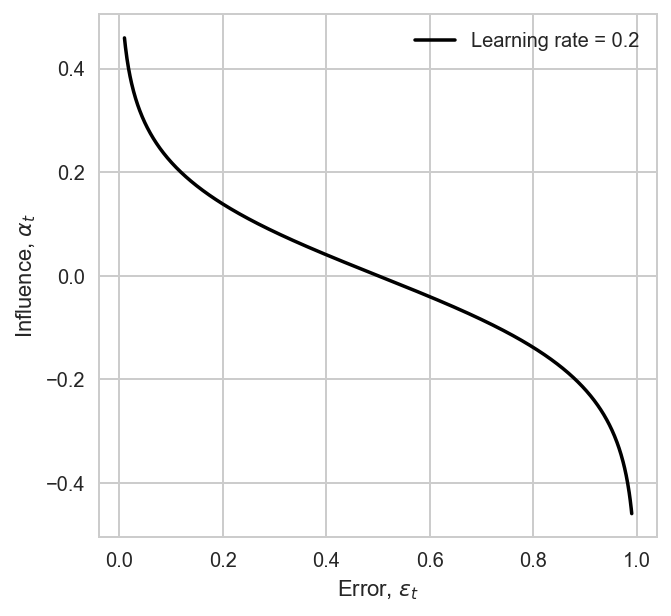

In [2]:
eta = 0.2
x = np.linspace(0.01, 0.99, 1000)
y = eta * 1/2 * np.log(1/x - 1)

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(x, y, 'k', label=fr'Learning rate = {eta}')
ax.axis('scaled')
ax.set_xlabel(r'Error, $\epsilon_t$')
ax.set_ylabel(r'Influence, $\alpha_t$')
ax.legend()
plt.show()

### Implementation
The classes
<code style='font-size:13px'><a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html">AdaBoostClassifier</a></code>
and
<code style='font-size:13px'><a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html">AdaBoostRegressor</a></code>
have the following Boosting hyperparameters:
- <code style='font-size:13px; color:#BA2121'>base_estimator</code>: the algorithm to be boosted, defaults to *None* (Decision Tree with max depth of 1).
- <code style='font-size:13px; color:#BA2121'>n_estimators</code>: the number of boosting stages ($T$), defaults to *50*.
- <code style='font-size:13px; color:#BA2121'>learning_rate</code>: the learning rate ($\eta$), defaults to *1*.

In [2]:
import numpy as np
import pandas as pd
np.set_printoptions(precision=4, suppress=True)

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor

In [39]:
dfCancer = pd.read_csv('data/breast_cancer.csv')
x = dfCancer.drop(columns='target')
y = dfCancer.target
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=1/5, random_state=1)
xTrain, xValid, yTrain, yValid = train_test_split(xTrain, yTrain, test_size=1/4, random_state=1)

In [49]:
modelBase = DecisionTreeClassifier(max_depth=1)
ensembler = AdaBoostClassifier(modelBase, n_estimators=50, learning_rate=1)

In [50]:
models = [ensembler]
for model in models:
    model = model.fit(xTrain, yTrain)
    yPred = model.predict_proba(xTest)[: ,1]
    auc = roc_auc_score(yTest, yPred)
    print(f'AUC = {auc:.4f} [{model.__class__.__name__}]')

AUC = 0.9828 [AdaBoostClassifier]


# 2. Gradient Boosting
[Grandient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting) is another boosting strategy beside Adaptive Boosting. The idea of this method is mostly inspired by [Gradient Descent](https://en.wikipedia.org/wiki/Gradient_descent), thus the name Gradient Boosting. Just like other ensembling methods, this algorithm works best on Decision Trees and becomes the foundation for its modern variants such as XGBoost, LightGBM and CatBoost.

Gradient Boosting Trees was originally designed for regression problems. For classification, we use regression approach to predict [log of the odds](https://en.wikipedia.org/wiki/Logit).

## 2.1. The algorithm
*Input:*
- A dataset having $N$ labeled observations $(\mathbf{X},\mathbf{y})=\{(\mathbf{o}_n,y_n)\}_{n=1}^N$
- The number of weak models, $T$
- The learning rate, $\eta$
- A [differentiable](https://en.wikipedia.org/wiki/Differentiable_function) loss function $\mathcal{L}(\mathbf{y},\hat{\mathbf{y}})$ ([squared error](https://en.wikipedia.org/wiki/Residual_sum_of_squares) is a popular choice)

*Step 1.* Initialize the prediction as a constant. Since this is the very first prediction and will be updated step-by-step, we denote this value $\hat{\mathbf{y}}^{(0)}$. When the loss function is MSE, this value is nothing but the mean of $\mathbf{y}$.

$$\hat{\mathbf{y}}^{(0)}=\underset{\hat{\mathbf{y}}^{(0)}}{\arg\min}\sum_{n=1}^N \mathcal{L}(y_n,\hat{y}_n^{(0)})$$

*Step 2.* For $t=1$ to $T$:

   - Compute the psuedo-residual $r_n^{(t)}$ equals to the derivative of the loss function with respect to the prediction of the iteration $t-1$. When MSE is used, this term is proportional to the actual residual, $y_n-y_n^{(t-1)}$. Thus, we call it psuedo-residual for generalization, which allows plugging in different loss functions.
   
   $$r_n^{(t)}=-\frac{\partial\mathcal{L}(y_n,\hat{y}_n^{(t-1)})}{\partial \hat{y}_n^{(t-1)}}$$

   - Fit a weak learner (regression tree) $f^{(t)}$ using the training set $(\mathbf{X},\mathbf{r}^{(t)})$. This step results in a tree with $J$ leaf nodes; meaning the input space is split into $J$ [disjoint](https://en.wikipedia.org/wiki/Disjoint_sets) regions, each region is denoted $R_j\;(j=1,2,\dots,J)$. Trees in this step are not restricted to be stumps as in AdaBoost.
   
   - Compute $f^{(t)}(\mathbf{X})$, the predicted value for the model $f^{(t)}$ so that it minimizes the loss function at step $t$.
   
   $$f^{(t)}(\mathbf{X})=\underset{f^{(t)}(\mathbf{X})}{\arg\min}\sum_{\mathbf{x}_n\in R_j}{L(y_n,F_{t-1}(\mathbf{x}_n)+\hat{y})}$$
   
   - Compute $\hat{y}_j^{(t)}$, the predicted value for the model $f_t$. By using first-order [Taylor approximation](https://en.wikipedia.org/wiki/Taylor_series), it can be proved that $\hat{y}_j^{(t)}$ is proportional to the negative gradient $r_n^{(t)}$. When MSE is chosen as the loss function, $\hat{y}_j^{(t)}$ is the average residual in the leaf $R_j$. As $\hat{y}_j^{(t)}$ is added to the final prediction $F$ at each iteration, this can be considered a Gradient Descent algorithm.
   
   $$\hat{y}_j^{(t)}=\underset{\hat{y}}{\arg\min}\sum_{\mathbf{x}_n\in R_j}{L(y_n,F_{t-1}(\mathbf{x}_n)+\hat{y})}$$
   
   - Update the strong model $F_t$ by adding the current weak predictor scaled by the learning rate. The formula uses the [indicator notation](https://en.wikipedia.org/wiki/Indicator_function).
   
   $$F_t(x)=F_{t-1}(x)+\eta\sum_{j=1}^{J_t}{\hat{y}_j^{(t)}\mathbf{1}_{R_j}(x)}$$
   
*Step 3*. Take the last strong model as the final predictor: $F\leftarrow F_t$. Note that in Gradient Boosting, the $t^{th}$ learner $F_t$ has taken into account all  weak learners up to the current iteration. Not like in Adaptive Boosting, the strong model is only built once all weak leaners was trained successfully.

## 2.2. Implementation
The
<code style='font-size:13px'><a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html">GradientBoostingClassifier</a></code>
and
<code style='font-size:13px'><a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html">GradientBoostingRegressor</a></code>
classes are the original impelementation of Gradient Boosting Trees. After a while,
<code style='font-size:13px'><a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html">HistGradientBoostingClassifier</a></code>
and
<code style='font-size:13px'><a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html">HistGradientBoostingRegressor</a></code>
which use histogram-based split finding were introduced. The later implementation is significantly faster for big datasets. The common hyperparameters of these algorithms are:
- <code style='font-size:13px; color:#BA2121'>loss</code>: the type of loss function, defaults to *deviance* (classification) and *squared_error* (regression).
- <code style='font-size:13px; color:#BA2121'>n_estimators</code>: the number of boosting stages ($T$), defaults to *100*.
- <code style='font-size:13px; color:#BA2121'>learning_rate</code>: the learning rate ($\eta$), defaults to *0.1*.
- <code style='font-size:13px; color:#BA2121'>max_features</code>: the ratio of features used in each tree, defaults to *auto* (square root of *nFeature*). A lower value increases bias and reduces variance.
- <code style='font-size:13px; color:#BA2121'>subsample</code>: the ratio of instances used in each tree, defaults to *1* (100% of *nSample*). A lower value increases bias and reduces variance.
- <code style='font-size:13px; color:#BA2121'>criterion</code>: the measure of quality of splits, defaults to *friedman_mse*.

In [34]:
import numpy as np
import pandas as pd
np.set_printoptions(precision=4, suppress=True)

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

In [39]:
dfCancer = pd.read_csv('data/breast_cancer.csv')
x = dfCancer.drop(columns='target')
y = dfCancer.target
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=1/5, random_state=1)
xTrain, xValid, yTrain, yValid = train_test_split(xTrain, yTrain, test_size=1/4, random_state=1)

In [40]:
model1 = GradientBoostingClassifier(random_state=7)
model2 = HistGradientBoostingClassifier(random_state=7)
models = [model1, model2]

for model in models:
    model = model.fit(xTrain, yTrain)
    yPred = model.predict_proba(xTest)[: ,1]
    auc = roc_auc_score(yTest, yPred)
    print(f'AUC = {auc:.4f} [{model.__class__.__name__}]')

AUC = 0.9729 [GradientBoostingClassifier]
AUC = 0.9831 [HistGradientBoostingClassifier]


# 3. XGBoost
[XGBoost](https://en.wikipedia.org/wiki/XGBoost) (e**X**treme **G**radient **Boost**ing).

## 3.1. The algorithm

### XGBoost Trees
Same as in GBM, XGBoost also requires a [differentiable](https://en.wikipedia.org/wiki/Differentiable_function) loss function $L(\mathbf{y},\hat{\mathbf{y}})$ as input, but it develops a unique tree structure, in which different loss functions can be plugged in. For each type of loss function, XGBoost considers its [gradient](https://en.wikipedia.org/wiki/Gradient) and [hessian](https://en.wikipedia.org/wiki/Hessian_matrix) (denoted $g_i$ and $h_i$, since they are calculated for each observation). These terms are usually used in the context of multivariate calculus, which are the vector of first-order partial derivatives and the matrix of second-order partial derivatives. However, in this case, they simply refer to the first and second derivatives with respect to the predicted variable.

There are two significant differences between XGBoost Trees and traditional CARTs:

- Information gain. There is a slightly difference in how XGBoost calculates information gain: it doesn't normalize impurity values of child nodes before calculating the reduction. The main difference is the impurity formula, it now takes into account the gradient and the hessian, as well as has room for regularization terms:

$$\text{Impurity}=-\frac{1}{2}\frac{(\sum g_n)^2}{\sum h_n+\lambda}+\gamma$$

- Prediction value. XGBoost uses another formula for prediction:

$$\text{Output}=-\frac{\sum g_n}{\sum h_n+\lambda}$$

### Objective function
XGBoost's authors strongly emphasize the role of regularization, which is usually treated less carefully in other tree packages. The objective function is defined so that it consists of two components, the loss term $\mathcal{L}$ and the regularization term $\mathcal{R}$.

*Loss term*. There are a lot of choices for loss functions, but let's start with the most friendly one, squared error.

$$\mathcal{L}(\mathbf{y},\hat{\mathbf{y}})=\sum_{n=1}^{N}\frac{1}{2}(\hat{y}_n-y_n)^2$$

Now let's observe XGBoost trees in the case of the most basic choice of loss function, squared error:

$$\mathcal{L}(\mathbf{y},\hat{\mathbf{y}})=
\sum_{n=1}^{N}\mathcal{L}(y_n,\hat{y}_n)=\sum_{n=1}^{N}\frac{1}{2}(\hat{y}_n-y_n)^2$$

For each observation $\mathbf{o}_n$, the corresponding gradient is $g_n=\hat{y}_n-y_n$ (refers to the residual) and hessian is $h_n=1$ (refers to the size). Plugging in the prediction formula, we can easily see that it *somewhat* represents the average of residuals, which is the same as in GBM. This gives us an intuition of what do gradient and hessian mean; the same idea can be applied to understand other loss functions.

### Regularization
In application, XGBoost's authors strongly emphasize the role of regularization, which is defined as model complexity. We denote $M$ the number of leaves and $y_m$ the score given by $m^{th}$ leaf ($m=1,2,\dots,M$), then the objective function is defined as follows:

$$
\mathcal{R}(\mathbf{y},\hat{\mathbf{y}})
=\gamma M+\frac{1}{2}\lambda\sum_{m=1}^{M}{y_m^2}
$$

There are other definitions of model complexity, but according to the authors, this formula works well in practice.

### Mathematical details


## 3.2. The algorithm

### Signing
- $O_{value}$: Output value
- $\lambda$ : Regulaziration parameter
- $\gamma$: Tree complexity parameter
- $\eta$: Learning rate
- Gradient ($g$): First derivative of loss function
- Hessian ($h$): Second derivative of loss function
- Residual :$r$
- Number of residual: $N_r$

### Mathematical details

The first step of fitting XGboost to the training data is making the initial prediction $p_0$ (default is `0.5` for both regression and classification). Like GBM, XGboost fit a tree to the residual of each observation but each tree in XGboost is unique. XGB build a tree which try to minimize the equation:
$$\sum_{i=1}^{n}L(y_i,p_{i}^0+O_{value}) + \frac{1}{2}\lambda*{O^2_{value}}  \space \mbox{(1)}$$
with $L$ is *loss function* and ($\frac{1}{2}\lambda*{O^2_{value}}$) is *regularization term*.\
The goal of XGB is finding the optimal output value to minimize the equation $(1)$.

To make an Xgboost tree, firstly we calculate the residuals of each obs different to initial prediction then making similariry score for the root:
$$\mbox{Similariry Score} = \frac{(\sum gradient)^2}{\sum hessian + \lambda}$$
Similarity score tell us the similarity between residual of observations, if residuals is different, they cancel out the others so that the similarity score will be small. And $\lambda$ is the regularization parameter, it's intend to reduce the prediction's sensitivity to individual observations and then prevent overfitting. When $\lambda$ increase, the similarity score wil be decrease - the amount of decrease is inversely proportional to the number of residual in the node.\
After having the similarity for the root, we find an optimal split point for the tree. We'll choose one threshold to split the obs and then calculating similarity score for each node. To quantify how much better the leaves similar residual than the root, we calculate the gain:
$$\mbox{gain} = \mbox{left}_{similarity} + \mbox{right}_{similarity} - \mbox{root}_{similarity}$$

We can compare the gain of this thresold to the others and the threshold which made the largest gain will be chosen. Continue building tree with other feature until getting the maximum split.

Now we have the full tree, to prune the tree, we use $\gamma$ parameter. If $gain - \gamma < 0$, we prune that leave.

Next step is find the output for each leaf of the tree. To do that, we derivate the equation $(1)$ and we get the formular for optimal output:
$$O_{value}=\frac{-\sum gradient}{\sum hessian + \lambda}$$

The larger $\lambda$, the closer output value to 0.\
Finally, we use the output value plus learning rate to make the new prediction:
$$p_0 + \sum_{m=1}^{m}\eta * O_{value}$$

Like GBM, the process go on with the next tree which is build based on residual of previous tree. And ending by reaching the smallest residual or maximum tree.


### Application in regression

In regression, XGB use loss function just like GBM:
$$L(y_i,p_i) = \frac{1}{2}(y_i-p_i)^2$$

Then gradient and hessian of loss function is :
$g_i = -(y_i-p_i)$ and $h_i = 1$

Replace to $O_{value}$ and similarity score we will have:
$$O_{value} = \frac{\sum r}{N_r + \lambda}$$

$$\mbox{similarity score} = \frac{\sum r^2}{N_{r} + \lambda} $$

### Application in classification

In classification, the loss function is the negative likelihood:
$$L(y_i,p_i) = -[y_i*log(p_i) + (1-y_i)*log(1-p_i)]$$
Then gradient and hessian of loss function is: 
$g_i = -(y_i-p_i)$ and $h_i = p_i*(1-p_i)$

Replace we have:
$$O_{value} = \frac{\sum r}{N_r + \lambda}$$

$$\mbox{similarity score} = \frac{\sum r^2}{cover+ \lambda} $$
with $Cover = \sum h_i= \sum[\mbox{previous prob}*(1-\mbox{previous prob})]$ 

Despite making probability as a new prediction, we predict $log(odds)$ of prediction then convert to probability (because ouput value is the $log(odds)$ now):

$$log(odds) prediction = log(\frac{p_0}{1-p_0}) + \eta*O_{value}$$

## 3.2. Implementation

In [42]:
import numpy as np
import pandas as pd
np.set_printoptions(precision=4, suppress=True)

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

In [65]:
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=7)

In [66]:
clf = XGBClassifier(eval_metric='error', use_label_encoder=False)

model = clf.fit(xTrain, yTrain)
yPred = model.predict_proba(xTest)[: ,1]
auc = roc_auc_score(yTest, yPred)
print(f'AUC = {auc:.4f} [{model.__class__.__name__}]')

AUC = 1.0000 [XGBClassifier]


# 4. LightGBM
[LightGBM](https://lightgbm.readthedocs.io/en/latest/) (**Light** **G**radient **B**oosting **M**achines) is an implementation of Gradient Boosting developed by Microsoft in order to deal with large datasets. According to [LightGBM paper](https://proceedings.neurips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf), *the main cost in GBDT lies in learning the decision trees, and the most time-consuming part in learning a decision tree is to find the best split points*. XGBoost has developed histogram-based split finding that reduces the complexity of the algorithm from $O(\#instance \times \#feature)$ to $O(\#bin \times \#feature)$ where $\#bin\ll \#instance$, which outperforms other implementations in terms of memory consumption.

However, XGBoost still does not meet the satisfactory of scalability when working on large datasets. To improve the performance of previous implementations, LightGBM introduces two novels techniques, GOSS (**G**radient-based **O**ne-**S**ide **S**ampling) for reducing data instances and EFB (**E**xclusive **F**eature **B**undling) for reducing data dimensions.

## 4.1. The algorithm

### One-side sampling
As the purpose of GOSS is to smartly sample data, it requires sample weights to achieve this. Althought Gradient Boosting does not have any native weight as in Adaptive Boosting, we can use residuals (generally gradients) as pseudo-weights. The GOSS algorithm is implemented right before the training of each weak learner and is described as follows.

*Input:*
- A dataset of $N$ observations and their corresponding gradients computed from the most recent predictor
- $a$ - the sampling ratio of large gradient data and $b$ - the sampling ratio of small gradient data ($a+b$ should not be greater than $1$)

*Step 1:* Sort (in descending order) the observations by the absolute values of their gradients and select top $\lfloor aN \rfloor$ observations. This under-trained set is what the training of the next tree should focus on.

*Step 2:* Perform random sampling $\lfloor bN \rfloor$ observations from the rest of the data. In order to compensate the information losses that affect data distribution, each instance in this well-trained set is amplified by a constant $\frac{1-a}{b}>1$ when calculating information gain in the next tree. "One-side sampling" in fact means that sampling is done on the small gradient side.

*Step 3:* Combine the under-trained set and the well-trained set above to form a single set to be used in learning the Decision Tree. By using this technique, *we put more focus on the under-trained instances without changing the original data distribution by much*.

### Exclusive feature bundling
One of the biggest problems that occur in high dimensional data is the sparsity. Sparse features spend A specific case is when some features *never* or *rarely* take non-zero values *simultaneously*; such features are called *mutually exclusive*. A typical situation is that features returned by an one-hot encoder are perfectly mutually exclusive. This situation is rarely met in real-world datasets, thus the EFB algorithm allows a small fraction of conflicts. To achieve this, two questions need to be answered: (1) *Which features should be bundled together?* and (2) *How to construct the bundles?*.

*Step 1:* Greedy bundling.

- Construct a graph whose weights correspond the total conflicts between features, then order the features by their degrees in the graph in the descending order. By using this ordered list, we are priortizing features with high probability of having conflicts. Another ordering strategy which further improves the efficiency is sorting by the number of non-zero values.

- Check each feature in the ordered list, either assign it to an existing bundle if the conflict rate is smaller than a preconfigured constant, or create a new bundle.
   
*Step 2:* Merging exclusive features. The key is to ensure features' values do not overlap and can be identified after bundling. This can be achieve by adding an offset to the original values of each feature so that features reside in different bins. Assume a bundle has 3 features $\mathbf{x}_1$, $\mathbf{x}_2$ and $\mathbf{x}_3$; their values ranges are $[0,20)$, $[10,15)$ and $[0,5)$. We add to these features consecutively offset values of $0$, $20$ and $35$, resulting in new feature ranges of $[0,20)$, $[30,35)$ and $[35,40)$. Now it's safe to merge all the three features into a single bundle with range $[0,40)$.

The EFB algorithm is processed only once before training, however, because of having the complexity of $O(\#feature^2)$, it may still suffer if there are millions of features.

### Other improvements
- [Optimization in speed and memory usage](https://lightgbm.readthedocs.io/en/latest/Features.html#optimization-in-speed-and-memory-usage). As in XGBoost, LightGBM also uses histogram-based split finding and histogram substraction to reduce calculation cost.
- [Optimization in accuracy](https://lightgbm.readthedocs.io/en/latest/Features.html#optimization-in-accuracy). LightGBM grows trees leaf-wise instead of level-wise as in most Decision Tree learning algorithms. This strategy chooses the leaf with highest delta loss to grow. For the same amount of leaves, leaf-wise approach tends to achieve a lower bias. This may sometimes cause overfitting, but this issue can be address by decreasing the max depth or number of leaves of tress.
- [Categorical features support](https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html#categorical-feature-support). LightGBM has a built-in mechanism to work with categorical features.
- [Optimization in distributed learning](https://lightgbm.readthedocs.io/en/latest/Features.html#optimization-in-distributed-learning). LightGBM supports three parallelization algorithms which fit in different scenarios.

||Small data|Large data|
|:--|:--|:--|
|**Small dimensional**|Feature parallel|Data parallel|
|**High dimensional**|Feaure parallel|Voting parallel|

- [Continued training](https://lightgbm.readthedocs.io/en/latest/Parameters.html#continued-training-with-input-score). LightGBM can continue training with initial scores.
- [GPU support](https://lightgbm.readthedocs.io/en/latest/GPU-Tutorial.html). LightGBM supports GPU training for accelaration.
- [DART](https://xgboost.readthedocs.io/en/stable/tutorials/dart.html). LightGBM also supports the DART boosting technique as XGBoost does.
- [Piece-Wise Linear Regression Trees](https://lightgbm.readthedocs.io/en/latest/Parameters.html#linear_tree).
- [Monotone constraints](https://lightgbm.readthedocs.io/en/latest/Parameters.html#monotone_constraints_method).
- [Cost efficient gradient boosting](https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html#cost-efficient-gradient-boosting).

## 4.2. Hyperparameters
The LightGBM algorithm has a huge number of [hyperparameters](https://lightgbm.readthedocs.io/en/latest/Parameters.html), devided into many types. Some of them have aliases, which makes LightGBM compatible with other libraries.

*Boosting parameters*. The configurations for boosting.
- <code style='font-size:13px; color:#BA2121'>boosting</code>: the ensemble method, defaults to *gdbt* (traditional GBM). Other options are *rf* (Random Forest), *goss* (Gradient-based One-Side Sampling) and *dart* (Dropouts meets Multiple Additive Regression Trees).
- <code style='font-size:13px; color:#BA2121'>n_estimators</code>: the number of boosting stages ($T$), defaults to *100*. Larger is usually better, but should go with a lower *learning_rate* and an *early_stopping_round* provided. Lower can speed up training.
- <code style='font-size:13px; color:#BA2121'>learning_rate</code>: the learning rate ($\eta$), defaults to *0.1*. Same usage as in GBM.
- <code style='font-size:13px; color:#BA2121'>early_stopping_round</code>: the maximum number of iterations without improvements, defaults to *0* (disabled). Keeping a low enough value may make boosting stop earlier, thus reduces the overall training time. Usually be set around $10\%$ of *n_estimators*.
- <code style='font-size:13px; color:#BA2121'>tree_learner</code>: the parallelization strategy, defaults to *serial* (single machine, no parallel). Other options are *feature*, *data* and *voting*.

*Bagging parameters*. LightGBM even includes more bagging parameters compared to Scikit-learn.
- <code style='font-size:13px; color:#BA2121'>bagging_fraction</code>: the ratio of data (instances) used in each tree, defaults to *1*. A lower value will increase the randomness between trees that deals with overfitting and may speed up training.
- <code style='font-size:13px; color:#BA2121'>bagging_freq</code>: the iteration frequency to perform bagging, defaults to *0* (disable bagging). A positive value will decrease the randomness between trees.
- <code style='font-size:13px; color:#BA2121'>pos_bagging_fraction</code> and <code style='font-size:13px; color:#BA2121'>neg_bagging_fraction</code>: the ratio of positive/negative samples used in each tree, both default to *1*. This pair of parameters should be used together to handle imbalance binary classification problems.
- <code style='font-size:13px; color:#BA2121'>feature_fraction</code>: the ratio of features used in each tree, defaults to *1*. A lower value will increase the randomness between trees that deals with overfitting and may speed up training.
- <code style='font-size:13px; color:#BA2121'>feature_fraction_bynode</code>: same as *feature_fraction*, but the sampling is done on tree nodes instead of trees; also defaults to *1*. A lower value can reduce overfitting but cannot speed up training.
- <code style='font-size:13px; color:#BA2121'>extra_trees</code>: whether to use Extremely Randomized Trees or not, defaults to *False*. This parameter increases the randomness, thus can deal with overfitting.

*Tree learning parameters*. Most parameters in this group are for prunning trees in order to deal with overfitting. Due to the fact that pruned trees are shallower, the training is also faster.
- <code style='font-size:13px; color:#BA2121'>num_leaves</code>: the maximum number of leaves in each tree, defaults to *31*. Since LightGBM grows trees leaf-wise, this is the main hyperparameter to control the complexity of trees. Optimal values range from $50\%$ to $100\%$ of $2^{\text{max_depth}}$.
- <code style='font-size:13px; color:#BA2121'>min_samples_leaf</code>: the minimum number of data a leaf must have, defaults to *20*. The next important parameter to prevent overfitting, its optimal value depends on training data size and *num_leaves*. Practical values for large datasets range from hundreds to thousands.
- <code style='font-size:13px; color:#BA2121'>max_depth</code>: the maximum depth of each tree, defaults to *-1* (no depth limitation). Another important parameter that controls overfitting; however, it is less effective on leaf-wise compared to level-wise implementations. A value from 3 to 13 works well for most datasets.
- <code style='font-size:13px; color:#BA2121'>min_sum_hessian_in_leaf</code>: the minimum sum of Hessian (the second derivative of the objective function for each observation) of each leaf, defaults to *0.001*. When the loss function is MSE, its second derivative is $1$; the sum of Hessian in this case equals to the number of data. For other loss function, this parameter has different meanings and also has different optimal values. Thus, unless you know what you are doing, this parameter should be left alone.
- <code style='font-size:13px; color:#BA2121'>min_gain_to_split</code>: the minimum information gain required to perform a split, defaults to *0*. In practice, very small improvements in the training loss have no meaningful impact on the generalization error of the model. A small value of this parameter is enough if used.
- <code style='font-size:13px; color:#BA2121'>reg_alpha</code> and <code style='font-size:13px; color:#BA2121'>reg_lambda</code>: the L1 and L2 regularization terms, both default to *0*. Optimal values are $10^k$ where $k$ is around $0$.
- <code style='font-size:13px; color:#BA2121'>linear_tree</code>: whether to use Piece-Wise Linear Regression Trees, defaults to *False*.
- <code style='font-size:13px; color:#BA2121'>linear_lambda</code>: the coefficient for linear tree regularization, defaults to *0*.

*Categorical split finding parameters*.
- <code style='font-size:13px; color:#BA2121'>categorical_feature</code>: specify categorical features, defaults to *auto*.
- <code style='font-size:13px; color:#BA2121'>min_data_per_group</code>: the minimum number of data per categorical group, defaults to *100*.
- <code style='font-size:13px; color:#BA2121'>cat_smooth</code>: the coefficient for categorical smoothing, defaults to *10*. Can reduce the effect of noises in categorical features, especially for ones with few data.
- <code style='font-size:13px; color:#BA2121'>max_cat_threshold</code>: the maximum number of splits considered for categorical features, defaults to *32*. Higher means more split points and larger search space. Lower reduces training time.
- <code style='font-size:13px; color:#BA2121'>cat_l2</code>: L2 regularization in categorical split, defaults to *10*.
- <code style='font-size:13px; color:#BA2121'>max_cat_to_onehot</code>: maximum number of categories of a feature to use one-hot encoding, otherwise the Fisher's split finding will be used, defaults to *4*.

*Histogram building parameters*.
- <code style='font-size:13px; color:#BA2121'>max_bin</code> and <code style='font-size:13px; color:#BA2121'>max_bin_by_feature</code>: the maximum number of bins when building histograms, defaults to *255*. The later parameter takes a list of intergers to specify the max number of bins for each feature. Smaller reduces training time but may hurt the accuracy.
- <code style='font-size:13px; color:#BA2121'>min_data_in_bin</code>: the minimum bin size, defaults to *3*. This parameter prevents bins from having a small number of data, as using their boundaries as splits isn’t likely to change the final model very much. Higher value reduces training time.
- <code style='font-size:13px; color:#BA2121'>bin_construct_sample_cnt</code>: the number of observations being sampled to determine bins, defaults to *200,000*. LightGBM only uses a part of data to find histogram boundaries, thus this parameter should not be set to a lower value. A higher value obviously improves prediction power but also leads to a longer data loading time.

*DART's parameters*
- <code style='font-size:13px; color:#BA2121'>drop_rate</code>: the fraction of previous trees to drop during the dropout, defaults to *0.1*.
- <code style='font-size:13px; color:#BA2121'>max_drop</code>: the max number of dropped trees during one boosting iteration, defaults to *50*.
- <code style='font-size:13px; color:#BA2121'>skip_drop</code>: the probability of skipping the dropout procedure during a boosting iteration, defaults to *0.5*.
- <code style='font-size:13px; color:#BA2121'>uniform_drop</code>: whether to use uniform drop or not, defaults to *False*.
- <code style='font-size:13px; color:#BA2121'>xgboost_dart_mode</code>: whether to enable XGBoost DART mode, which uses a bit different shrinkage rate, defaults to *False*.

*GOSS's parameters*
- <code style='font-size:13px; color:#BA2121'>top_rate</code>: the sampling ratio of large gradient data, defaults to *0.2*.
- <code style='font-size:13px; color:#BA2121'>other_rate</code>: the sampling ratio of small gradient data, defaults to *0.1*.

*Preprocessing parameteres*
- <code style='font-size:13px; color:#BA2121'>enable_bundle</code>: whether to use the EFB algorithm or not, defaults to *True*.
- <code style='font-size:13px; color:#BA2121'>enable_sparse</code>: whether to use sparse optimization, defaults to *True*.
- <code style='font-size:13px; color:#BA2121'>use_missing</code>: whether to use special handle of missing values, defaults to *True*.
- <code style='font-size:13px; color:#BA2121'>feature_pre_filter</code>: whether to ignore unsplittable features based on *min_samples_leaf*, defaults to *True*. As *min_samples_leaf* was set, some features will perform a split results in a leaf not having enough minimum number of data. Such features will be filtered out once before training. Also remember to tune *min_samples_leaf* before this parameter.

## 4.3. Implementation
LightGBM supports a lot of customizations and useful features:
- It accepts a wide range of different loss functions, can be either a [built-in one](https://lightgbm.readthedocs.io/en/latest/Parameters.html#objective), or a user-defined funnction with the signature:
<code style='font-size:13px'>loss(yTrue, yPred) -> (grad, hess)</code>.
- You can provide LightGBM validation sets and evaluation metrics, it will print out evaluation results at each stage. LightGBM allows you to control the logging frequency or even surpress it.
- It accepts either [built-in metrics](https://lightgbm.readthedocs.io/en/latest/Parameters.html#metric) or user-defined metrics with the signature:
<code style='font-size:13px'>eval(yTrue, yPred) -> (evalName, evalResult, isHigherBetter)</code>.
- It accepts validation set(s) and their corresponding names.
- You can create a [callback](<https://en.wikipedia.org/wiki/Callback_(computer_programming)>) that activates [early stopping](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.early_stopping.html) if one of the metrics doesn't improve after a number of rounds. At least one validation set must be provided to active early stopping.
- It can continue training if provided an existing model.
- LightGBM supports 2 feature importances calculating strategies: *split* (default) - the number of times a feature is used and *gain* - the total of information gain associated with a feature.
- You can specify a list of integer-encoded categorical features, since LightGBM has a special mechanism to work with them.

In [1]:
import numpy as np
import pandas as pd
np.set_printoptions(precision=4, suppress=True)

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor

In [2]:
dfCancer = pd.read_csv('data/breast_cancer.csv')
x = dfCancer.drop(columns='target')
y = dfCancer.target
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=1/5, random_state=1)
xTrain, xValid, yTrain, yValid = train_test_split(xTrain, yTrain, test_size=1/4, random_state=1)

### Scikit-learn API
The algorithm initialization syntax using
<code style='font-size:13px'><a href="https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html">LGBMClassifier</a></code>
and
<code style='font-size:13px'><a href="https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html">LGBMRegressor</a></code>
classes is the same as in Scikit-learn. Most of LightGBM's useful features are accessed using the
<code style='font-size:13px'><a href="https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier.fit">fit()</a></code>
method.

In [3]:
# create a model with 200 iterations
algo = LGBMClassifier(
    num_leaves=2**5,
    learning_rate=0.05,
    n_estimators=200,
    
    verbosity=-1,
    importance_type='gain',
)

# train the model with early stopping of 10% of number of trees
model = algo.fit(
    xTrain, yTrain,
    eval_set=[(xValid, yValid)],
    eval_names=['Valid'],
    eval_metric=['binary_logloss', 'auc'],
    callbacks=[
        lgb.early_stopping(20, first_metric_only=True),
        lgb.log_evaluation(period=20),
    ],
)

Training until validation scores don't improve for 20 rounds
[20]	Valid's binary_logloss: 0.245227	Valid's auc: 0.996284
[40]	Valid's binary_logloss: 0.129513	Valid's auc: 0.997635
[60]	Valid's binary_logloss: 0.0819823	Valid's auc: 0.998649
[80]	Valid's binary_logloss: 0.0640199	Valid's auc: 0.998986
[100]	Valid's binary_logloss: 0.0622647	Valid's auc: 0.998649
Early stopping, best iteration is:
[97]	Valid's binary_logloss: 0.0609187	Valid's auc: 0.998986
Evaluated only: binary_logloss


In [4]:
yTestPred = model.predict_proba(xTest)[: ,1]
auc = roc_auc_score(yTest, yTestPred)
print(f'AUC = {auc:.4f} [{model.__class__.__name__}]')

AUC = 0.9835 [LGBMClassifier]


In [5]:
model.feature_importances_

array([   2.7932,   61.9895,    0.7611,    0.3866,    3.8635,    0.4405,
        117.783 ,   96.1331,    3.7455,    0.2102,   10.3477,    5.8531,
         13.2454,   72.8923,    6.2065,    6.9134,    0.    ,   11.753 ,
          3.9254,    8.9424,  449.2814,  157.9406, 1878.1435,  754.576 ,
         44.5361,   43.9856,  241.9603,  494.7697,   21.146 ,    4.1357])

### LightGBM API
Beside Scikit-learn API, LightGBM also provides its own training API via the
<code style='font-size:13px'><a href="https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.train.html">train()</a></code>
function, which takes a
<code style='font-size:13px'><a href="https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.Dataset.html">Dataset</a></code>
object as input instead of NumPy arrays. The prediction step still takes NumPy arrays as input as in Scikit-learn. Learn more [here](https://github.com/microsoft/LightGBM/blob/master/examples/python-guide/advanced_example.py).

In [10]:
listFeatureCategorical = []
dataTrain = lgb.Dataset(xTrain, yTrain)
dataValid = lgb.Dataset(xValid, yValid, reference=dataTrain)
dataTest = lgb.Dataset(xTest, yTest, reference=dataTrain)

In [19]:
params = {
    'objective': 'binary',
    'metric': ['binary_logloss', 'auc'],
    
    'n_estimators': 200,
    'boosting_type': 'goss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    
    'verbose': -1,
    'force_col_wise': True
}
model = lgb.train(
    params=params,
    train_set=dataTrain,
    valid_sets=dataValid,
    callbacks=[
        lgb.early_stopping(20, first_metric_only=False),
        lgb.log_evaluation(period=20),
    ],
)

Training until validation scores don't improve for 20 rounds
[20]	valid_0's binary_logloss: 0.246778	valid_0's auc: 0.996622
[40]	valid_0's binary_logloss: 0.139876	valid_0's auc: 0.997297
[60]	valid_0's binary_logloss: 0.0911384	valid_0's auc: 0.997973
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.12314	valid_0's auc: 0.997973


In [23]:
yTestPred = model.predict(xTest)
auc = roc_auc_score(yTest, yTestPred)
print(f'AUC = {auc:.4f} [{model.__class__.__name__}]')

AUC = 0.9821 [Booster]


In [27]:
model.feature_importance('split')

array([ 3, 19,  4,  0,  9,  5, 12, 19,  3,  6, 10, 20,  7, 23,  5, 11,  2,
        5,  4,  3, 17, 20, 17, 20,  5,  8, 17, 46, 10,  3])

# 5. CatBoost
[CatBoost](https://en.wikipedia.org/wiki/Catboost) (**Cat**egorical **Boost**ing).

## 5.1. The algorithm

### Target encoding

### Ordered boosting

## 5.2. Implementation

In [38]:
import numpy as np
import pandas as pd
np.set_printoptions(precision=4, suppress=True)

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier, CatBoostRegressor

In [9]:
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.2, random_state=7)

In [17]:
clf = CatBoostClassifier()

model = clf.fit(xTrain, yTrain, logging_level='Silent')
yPred = model.predict(xTest)
auc = roc_auc_score(yTest, yPred)
print(f'AUC = {auc:.4f} [{model.__class__.__name__}]')

AUC = 0.9636 [CatBoostClassifier]


# References
- [Documentation] [Scikit-learn's ensemble methods](https://scikit-learn.org/stable/modules/ensemble.html)
- [Documentation] [XGBoost](https://xgboost.readthedocs.io/en/stable/index.html)
- [Documentation] [LightGBM](https://lightgbm.readthedocs.io/en/latest/)
- [Documentation] [CatBoost](https://catboost.ai/en/docs/)
- [Paper] [A short introduction to Boosting](http://www.cs.columbia.edu/~jebara/6772/papers/IntroToBoosting.pdf)
- [Paper] [XGBoost: A scalable tree boosting system](https://arxiv.org/pdf/1603.02754.pdf)
- [Paper] [LightGBM: A highly efficient Gradient Boosting Decision Tree](https://proceedings.neurips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf)
- [Paper] [CatBoost: Unbiased Boosting with categorical features](https://arxiv.org/pdf/1706.09516.pdf)
- [Paper] [DART: Dropouts meet Multiple Additive Regression Trees](https://arxiv.org/pdf/1505.01866.pdf)
- [Paper] [Gradient Boosting with Piece-Wise Linear Regression Trees](https://arxiv.org/pdf/1802.05640.pdf)
- [Paper] [Cost efficient gradient boosting](https://proceedings.neurips.cc/paper/2017/file/4fac9ba115140ac4f1c22da82aa0bc7f-Paper.pdf)
- [Towards Data Science] [Ensemble methods: bagging, boosting and stacking](https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205)

---
*&#9829; By Quang Hung x Thuy Linh &#9829;*

In [ ]:
# udf.py
# utility
from toolz import pipe, thread_first
from contextlib import suppress

# data manipulation
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh
from bokeh.plotting import figure
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, Band
from bokeh.plotting import figure
from bokeh.io import show

# config
plt.style.use(['seaborn', 'seaborn-whitegrid'])
output_notebook()
import warnings; warnings.filterwarnings('ignore')
    
def plot_forecasting(x, yTrue, yPred, ci90=None, ci95=None, ci99=None, history=True):
    
    cut = yPred.shape[0]
    df = x.append(yTrue).to_frame()
    df[['forecast', 'lower90', 'upper90', 'lower95', 'upper95', 'lower99', 'upper99']] = np.nan
    df.iloc[-cut:, 1] = yPred
    with suppress(AttributeError):
        df.iloc[-cut:, 2:4] = ci90.clip(min=0)
        df.iloc[-cut:, 4:6] = ci95.clip(min=0)
        df.iloc[-cut:, 6:8] = ci99.clip(min=0)
    df = df.reset_index()
    df.columns = ['date', 'ground_truth', 'forecast', 'lower90', 'upper90', 'lower95', 'upper95', 'lower99', 'upper99']
    df = df if history else df.iloc[-cut:, :]

    source = ColumnDataSource(df)

    fig = figure(plot_width=1000, plot_height=300, x_axis_type='datetime')
    fig.line(source=source, x='date', y='ground_truth', color='grey', legend_label='GroundTruth')
    fig.line(source=source, x='date', y='forecast', color='red', legend_label='Forecast')
    fig.circle(source=source, x='date', y='ground_truth', color='grey')
    fig.circle(source=source, x='date', y='forecast', color='red')
    
    fig.varea(source=source, x='date', y1='lower90', y2='upper90', fill_alpha=0.15, fill_color='grey', legend_label='CI 90%')
    fig.varea(source=source, x='date', y1='lower95', y2='upper95', fill_alpha=0.10, fill_color='grey', legend_label='CI 95%')
    fig.varea(source=source, x='date', y1='lower99', y2='upper99', fill_alpha=0.05, fill_color='grey', legend_label='CI 99%')
    
    fig.legend.location = 'top_left'
    fig.yaxis.formatter = bokeh.models.NumeralTickFormatter(format='0a')

    show(fig)

In [55]:
# manipulation
import numpy as np
import pandas as pd
from statsmodels import tsa
from toolz import pipe, thread_first

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import bokeh
from bokeh.plotting import figure
from bokeh.io import show, output_notebook
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from udf import plot_forecasting

# hypothesis testing
from statsmodels.tsa.stattools import adfuller

# algorithms
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR, SVAR, VARMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HW
from statsmodels.tsa.exponential_smoothing.ets import ETSModel as ETS
from pmdarima.arima import auto_arima as AutoARIMA
# from prophet import Prophet # cannot install

# evaluation
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error as MSE, mean_absolute_error as MAE, r2_score as R2

# configurations
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'
output_notebook()
import warnings; warnings.filterwarnings('ignore')

Loading BokehJS ...

In [2]:
dfWithdraw = pd.read_excel('032_withdraw_daily.xlsx')
dfWithdraw = dfWithdraw[['day', 'withdraw']]
dfWithdraw = dfWithdraw.set_index('day').asfreq('d').reset_index()
dfWithdraw['withdraw'] = dfWithdraw['withdraw'].fillna(1e-6) # add a smoothing coefficient
dfWithdraw.head()

,day,withdraw
0,2021-09-18,2.166255e+08
1,2021-09-19,1.040161e+09
2,2021-09-20,9.851213e+09
3,2021-09-21,9.933537e+09
4,2021-09-22,1.589220e+10


# 1. Identifying properties

## Auto-correlation
Both ACF and PACF shows that the correlation is high at $7k$ lags, which means these lags have both direct and indirect effect to the current moment. In other words, 7 is a potential value of period.

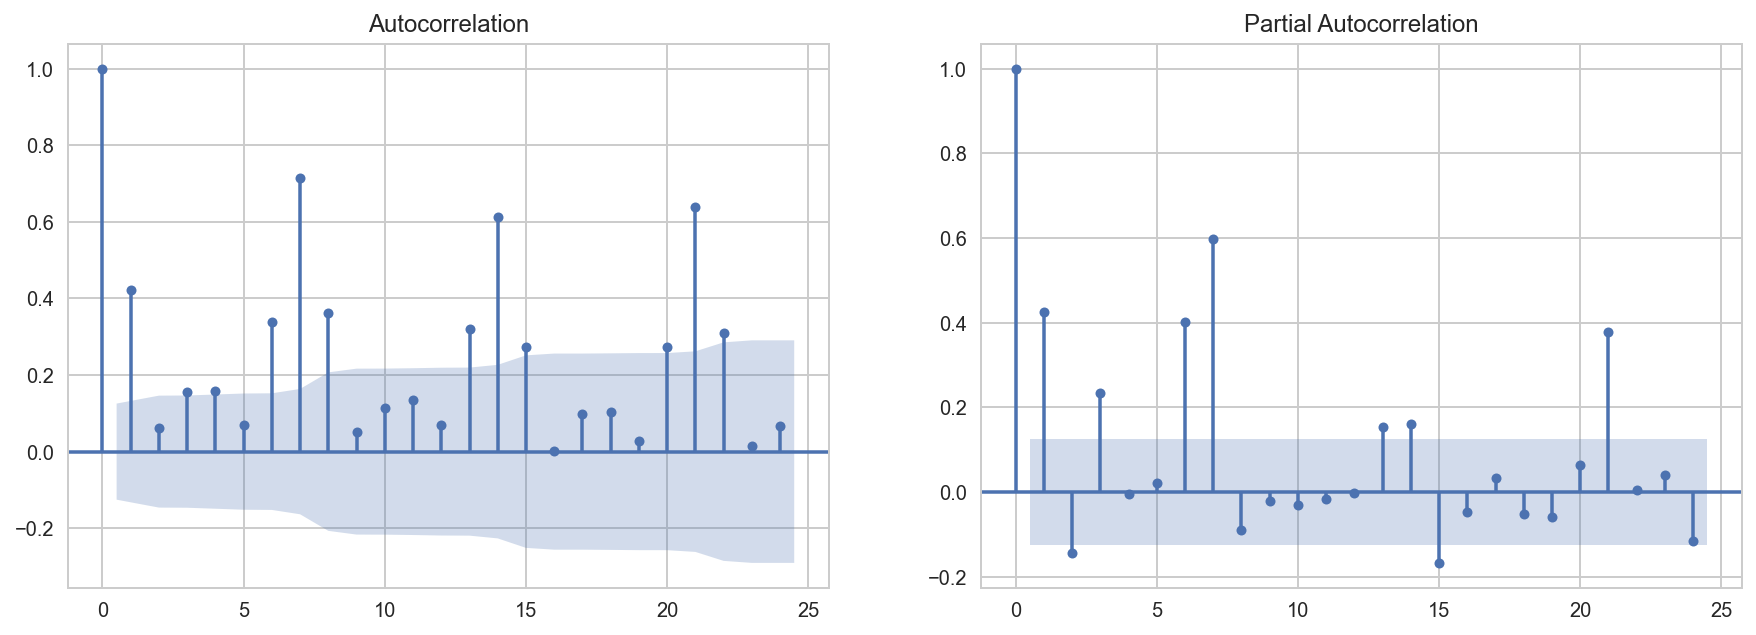

In [5]:
df = dfWithdraw.copy()

fig, ax = plt.subplots(ncols=2, figsize=(15,5))
plot_acf(df.withdraw, ax=ax[0])
plot_pacf(df.withdraw, ax=ax[1])
plt.show()

## Seasonality
Hypothesis: 7-day period

In [55]:
df = dfWithdraw.copy()
df['dayname'] = df['day'].dt.day_name()
df = df.groupby('dayname').agg(['mean', 'std'])
df.reset_index()

dayname      withdraw              
                      mean           std
0     Friday  2.646530e+11  1.469317e+11
1     Monday  3.240241e+11  1.972168e+11
2   Saturday  3.429039e+10  2.846833e+10
3     Sunday  2.606566e+10  2.119489e+10
4   Thursday  2.579350e+11  1.489467e+11
5    Tuesday  2.750641e+11  1.758080e+11
6  Wednesday  2.575419e+11  1.423150e+11

## Trend
Moving average

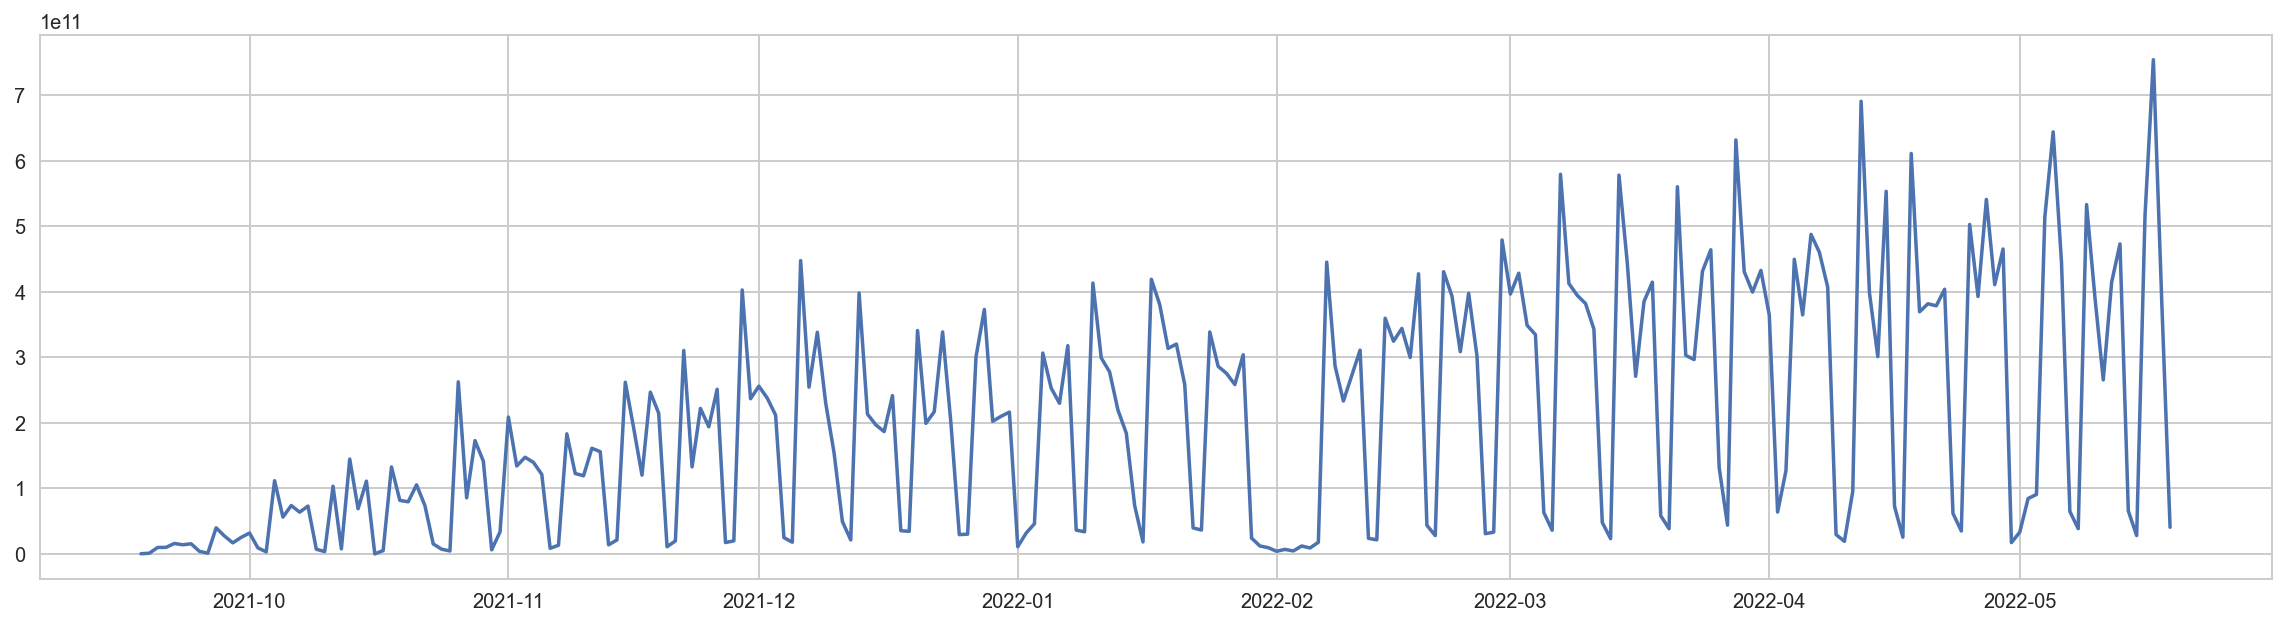

In [36]:
df = dfWithdraw.copy()
# df = df.iloc[50:80]
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(df.day, df.withdraw)
plt.show()

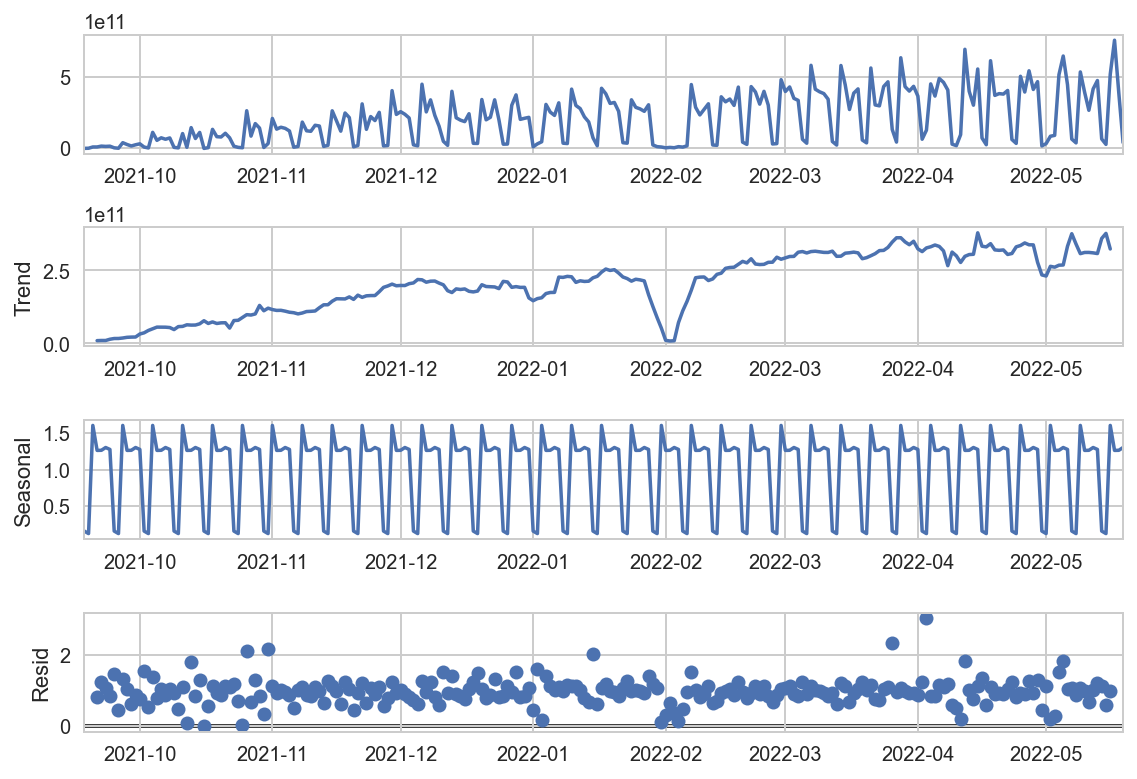

In [68]:
freq = 7

df = dfWithdraw.copy()
df = df.set_index('day')
decomposer = seasonal_decompose(df, model='multiplicative', freq=freq)
decomposer.plot()
plt.show()

In [69]:
decomposer.seasonal.head(freq)

day
2021-09-18    0.161593
2021-09-19    0.127132
2021-09-20    1.604538
2021-09-21    1.263177
2021-09-22    1.264709
2021-09-23    1.302594
2021-09-24    1.276258
Name: seasonal, dtype: float64

## Stationarity
Stationarity refers to a time series having a relative constant mean, constant variance and no seasonality (by looking at the time series plot). If at least one of the three contraints is violated, our data is non-seasonality.

Augmented Dickey-Fuller test:
- H<sub>0</sub>: data is non-stationary
- H<sub>1</sub>: data is stationary

If either p-value < significance level or test statistic < critical value: we reject H0 and conclude that our data is stationary.

In this case, ADF = 0.7678 > 0.05, thus the data is non-stationary. It's obvious that there are both trend and seasonality in the plot.

In [3]:
def test_stationary(s):
    from statsmodels.tsa.stattools import adfuller
    testSummary = adfuller(s, regression='nc')
    stat, pval, _, _, crits, _ = testSummary
    messFalse = f'p-value={pval:.6f} > 0.05, data is non-stationary'
    messTrue = f'p-value={pval:.6f} < 0.05, data is stationary'
    result = pval < 0.05
    print(messTrue) if result else print(messFalse)

In [4]:
test_stationary(dfWithdraw['withdraw'])

p-value=0.767844 > 0.05, data is non-stationary


In [106]:
test_stationary(np.log(dfWithdraw.withdraw))

p-value=0.795319 > 0.05, data is non-stationary


In [6]:
test_stationary(dfWithdraw.withdraw.diff(periods=1)[1:])

p-value=0.000000 < 0.05, data is stationary


# 2. Modeling

In [3]:
df = dfWithdraw.copy()

# configurations
nTrain, nTest = 24, 24

# cut points: start --- cutTrain --- cutTest --- end
n = df.shape[0]
cutTest = n - nTest
cutTrain = cutTest - nTrain

# train-test split, no validation
df = dfWithdraw.copy()
s = df.set_index('day').withdraw
xTrain, yTrain = s[0:cutTrain], s[cutTrain:cutTest]
xTest , yTest  = s[0:cutTest ], s[cutTest:]

## ARIMA

In [21]:
p, d, q = 7, 1, 2

modelTrain = ARIMA(xTrain, order=(p,d,q)).fit()
yTrainPred, _, ciTrain99 = modelTrain.forecast(nTrain, alpha=0.01)
yTrainPred, _, ciTrain95 = modelTrain.forecast(nTrain, alpha=0.05)
yTrainPred, _, ciTrain90 = modelTrain.forecast(nTrain, alpha=0.1)

rmseTrain = MSE(yTrain, yTrainPred, squared=False) / 1e9
maeTrain = MAE(yTrain, yTrainPred) / 1e9
r2Train = R2(yTrain, yTrainPred)

print(f'ARIMA | Train | RMSE={rmseTrain:.2f}b | MAE={maeTrain:.2f}b | R2={r2Train:.4f}\n')

plot_forecasting(xTrain, yTrain, yTrainPred, ciTrain90, ciTrain95, ciTrain99, history=False)

ARIMA | Train | RMSE=145.99b | MAE=114.74b | R2=0.5011



In [22]:
modelTest = ARIMA(xTest, order=(p,d,q)).fit()
yTestPred, _, ciTest99 = modelTest.forecast(nTest, alpha=0.01)
yTestPred, _, ciTest95 = modelTest.forecast(nTest, alpha=0.05)
yTestPred, _, ciTest90 = modelTest.forecast(nTest, alpha=0.1)

rmseTest = MSE(yTest, yTestPred, squared=False) / 1e9
maeTest = MAE(yTest, yTestPred) / 1e9
r2Test = R2(yTest, yTestPred)

print(f'ARIMA | Test | RMSE={rmseTest:.2f}b | MAE={maeTest:.2f}b | R2={r2Test:.4f}\n')

plot_forecasting(xTest, yTest, yTestPred, ciTest90, ciTest95, ciTest99, history=False)

ARIMA | Test | RMSE=182.47b | MAE=137.86b | R2=0.3414



## Auto ARIMA

In [24]:
modelAutoArima = AutoARIMA(
    xTrain, test='adf', m=7,
    start_p=0, max_p=7,
    start_q=0, max_q=7,
    d=1, max_d=2,
    start_P=0, max_P=5,
    start_Q=0, max_Q=5,
    D=0, max_D=2
)

In [25]:
modelAutoArima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  196
Model:             SARIMAX(1, 1, 2)x(1, 0, [1], 7)   Log Likelihood               -5211.604
Date:                             Wed, 25 May 2022   AIC                          10435.209
Time:                                     10:21:09   BIC                          10454.847
Sample:                                          0   HQIC                         10443.160
                                             - 196                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7415      0.345      2.150      0.032       0.066       1.417
ma.L1         -1.3971      0.461     -3.031      0.002      -2.301      -0.494
ma.L2          0.4055      0.440      0.921      0.357      -0.458       1.269
ar.S.L7        0.9563      0.050     19.115      0.000       0.858       1.054
ma.S.L7       -0.5832      0.175     -3.332      0.001      -0.926      -0.240
sigma2      1.846e+22   4.84e-24   3.81e+45      0.000    1.85e+22    1.85e+22
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                64.21
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               2.91   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.67e+62. Standard errors may be unstable.
"""

In [26]:
modelAutoArima.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (1, 1, 2),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (1, 0, 1, 7),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [28]:
yTrainPred, ciTrain90 = modelAutoArima.predict(24, alpha=0.10, return_conf_int=True)
yTrainPred, ciTrain95 = modelAutoArima.predict(24, alpha=0.05, return_conf_int=True)
yTrainPred, ciTrain99 = modelAutoArima.predict(24, alpha=0.01, return_conf_int=True)

rmseTrain = MSE(yTrain, yTrainPred, squared=False) / 1e9
maeTrain = MAE(yTrain, yTrainPred) / 1e9
r2Train = R2(yTrain, yTrainPred)

print(f'AutoARIMA | Train | RMSE={rmseTrain:.2f}b | MAE={maeTrain:.2f}b | R2={r2Train:.4f}\n')

plot_forecasting(xTrain, yTrain, yTrainPred, ciTrain90, ciTrain95, ciTrain99, False)

AutoARIMA | Train | RMSE=134.80b | MAE=93.20b | R2=0.5746



In [29]:
yTestPred, ciTest90 = modelAutoArima.fit_predict(xTest, n_periods=24, alpha=0.10, return_conf_int=True)
yTestPred, ciTest95 = modelAutoArima.fit_predict(xTest, n_periods=24, alpha=0.05, return_conf_int=True)
yTestPred, ciTest99 = modelAutoArima.fit_predict(xTest, n_periods=24, alpha=0.01, return_conf_int=True)

mseTest = MSE(yTest, yTestPred, squared=False) / 1e9
maeTest = MAE(yTest, yTestPred) / 1e9
r2Test = R2(yTest, yTestPred)

print(f'AutoARIMA | Test | RMSE={rmseTest:.2f}b | MAE={maeTest:.2f}b | R2={r2Test:.4f}\n')

plot_forecasting(xTest, yTest, yTestPred, ciTest90, ciTest95, ciTest99, False)

AutoARIMA | Test | RMSE=182.47b | MAE=117.75b | R2=0.4630



## Exponential Smoothing

In [39]:
paramsGrid = ParameterGrid({
    'error': ['add', 'mul'],
    'trend': ['add', 'mul'],
    'seasonal': ['add', 'mul'],
    'damped_trend': [True, False],
    'seasonal_periods': [7],
})

listRmse = []
for params in paramsGrid:
    model = ETS(xTrain, **params).fit()
    yTrainPred = model.get_prediction(cutTrain, cutTest-1).summary_frame()['mean']
    rmseTrain = MSE(yTrain, yTrainPred, squared=False) / 1e9
    listRmse.append(rmseTrain)

idxBest = pipe(listRmse, np.array, np.argmax)
paramsBest = paramsGrid[idxBest]

In [53]:
print(paramsBest)
print(min(listRmse))

{'trend': 'mul', 'seasonal_periods': 7, 'seasonal': 'mul', 'error': 'add', 'damped_trend': False}
124.16323359532464


In [58]:
modelEts = ETS(xTrain, **paramsBest).fit()
predictor95 = modelEts.get_prediction(cutTrain, cutTest-1).summary_frame()
yTrainPred = predictor95.iloc[:, 0]

ciTrain95 = predictor95.iloc[:, 2:].values

plot_forecasting(xTrain, yTrain, yTrainPred, ciTrain95, history=False)

In [56]:
modelEts = ETS(xTest, **paramsBest).fit()
predictor95 = modelEts.get_prediction(cutTest, n-1).summary_frame()
yTestPred = predictor95.iloc[:, 0]

ciTest95 = predictor95.iloc[:, 2:].values

plot_forecasting(xTest, yTest, yTestPred, ciTest95, history=False)

In [240]:
modelEts = ETS(xTrain, error='add', trend='add', damped_trend=True, seasonal='add', seasonal_periods=7).fit()
predictionEts = modelEts.get_prediction(cutTrain, cutTest-1, alpha=0.05)
predictionEts.summary_frame().head()

,mean,pi_lower,pi_upper
2022-04-02,1.017917e+11,-4.646348e+10,2.500469e+11
2022-04-03,6.721141e+10,-8.631907e+10,2.207419e+11
2022-04-04,5.881852e+11,4.295538e+11,7.468166e+11
2022-04-05,4.061801e+11,2.426058e+11,5.697543e+11
2022-04-06,3.659777e+11,1.976048e+11,5.343507e+11


In [244]:
modelEts = ETS(xTrain, trend='add', damped_trend=True, seasonal='add', seasonal_periods=7).fit()
predictionEts = modelEts.get_prediction(cutTrain, cutTest-1, alpha=0.1)
predictionEts.summary_frame().head()

,mean,pi_lower,pi_upper
2022-04-02,1.017917e+11,-4.646348e+10,2.500469e+11
2022-04-03,6.721141e+10,-8.631907e+10,2.207419e+11
2022-04-04,5.881852e+11,4.295538e+11,7.468166e+11
2022-04-05,4.061801e+11,2.426058e+11,5.697543e+11
2022-04-06,3.659777e+11,1.976048e+11,5.343507e+11
